In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 44.9 MB/s eta 0:00:00


# Importar datos

In [10]:
import zipfile
import os
import mne
import shutil

In [55]:
cnt_file = '/content/drive/MyDrive/SEED/EEG_raw/1_1_20180804.cnt'

raw_data = mne.io.read_raw_cnt(cnt_file, preload=True)

Reading 0 ... 3378359  =      0.000 ...  3378.359 secs...


Using matplotlib as 2D backend.


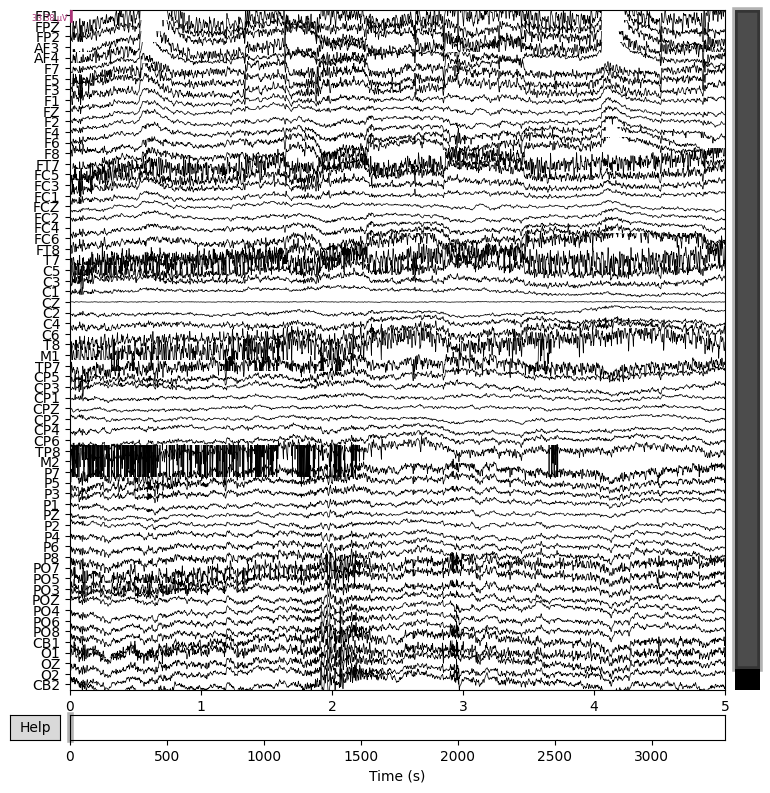

In [12]:
raw_data.plot(duration=5, n_channels=64, scalings='auto', title='Señales EEG', show=True, block=True);

In [56]:
canales_a_eliminar = ['M1', 'M2', 'VEO', 'HEO']

raw_data.drop_channels(canales_a_eliminar)

print("Canales restantes:")
print(raw_data.ch_names)

Canales restantes:
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2']


# Referenciar mediante la media

In [57]:
raw_data.set_eeg_reference(ref_channels='average')

raw_data.apply_proj()

print("Referencia de los datos después de la re-referenciación:", raw_data.info['custom_ref_applied'])

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
No projector specified for this dataset. Please consider the method self.add_proj.
Referencia de los datos después de la re-referenciación: 1 (FIFFV_MNE_CUSTOM_REF_ON)


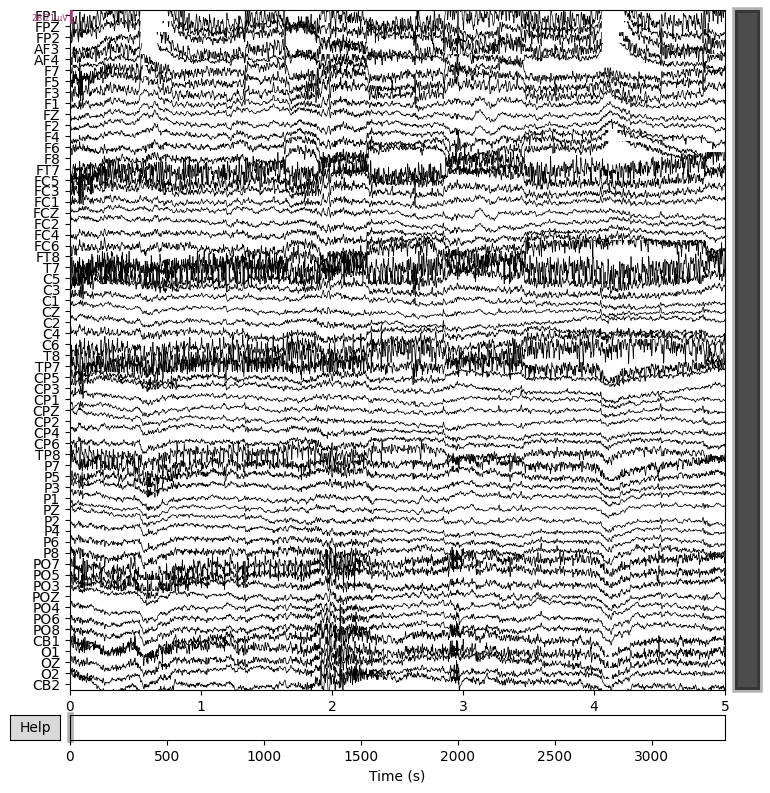

In [15]:
raw_data.plot(duration=5, n_channels=62, scalings='auto', title='Señales EEG', show=True, block=True);

# Filtrado de señales

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   10.4s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


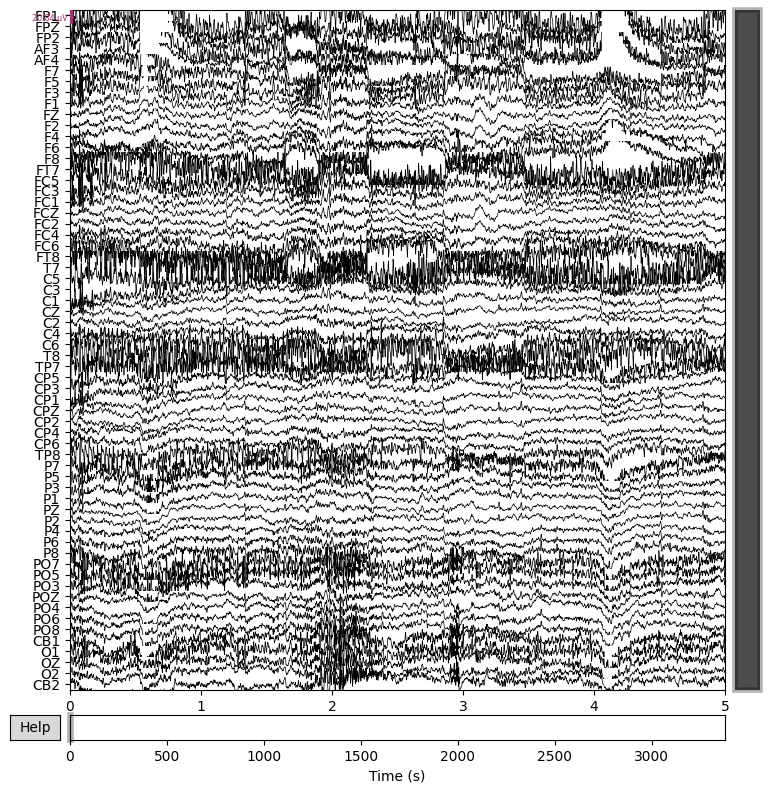

In [58]:
raw_data.filter(l_freq=0.5, h_freq=None)
raw_data.notch_filter(freqs=50)

raw_data.plot(duration=5, n_channels=62, scalings='auto', title='Señales EEG filtradas', show=True, block=True);

# Importar ubicación de electrodos

In [17]:
from IPython.display import Image

image_url = 'https://www.researchgate.net/publication/375764470/figure/fig1/AS:11431281205800121@1700485522933/62-channel-ESI-NeuroScan-System.ppm'

# Ubicación de electrodos en NeuroScan de 62 canales
Image(url=image_url, width=400)

In [59]:
locs_file_path = '/content/drive/MyDrive/SEED/channel_62_pos.locs'

montage = mne.channels.read_custom_montage(locs_file_path)

print("Nombres de los electrodos en el montaje:")
print(montage.ch_names)

Nombres de los electrodos en el montaje:
['Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'Oz', 'O2', 'CB2']


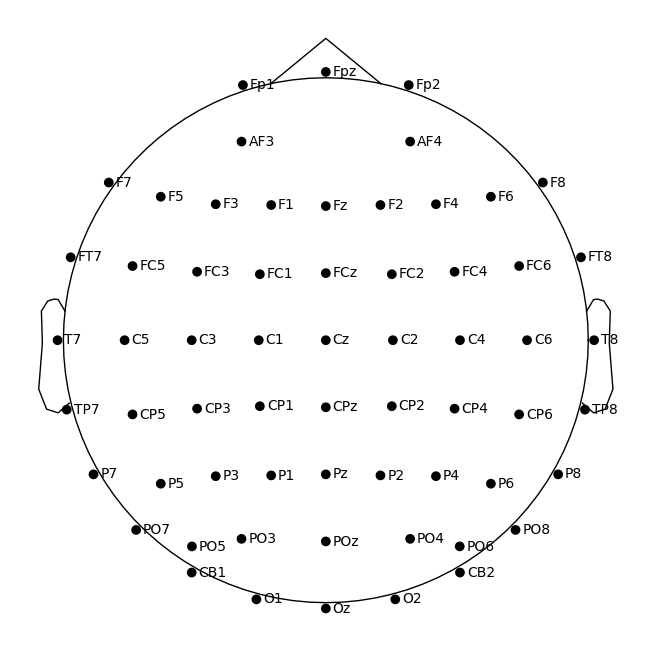

In [19]:
montage.plot(kind='topomap', show_names=True);

# Identificación de épocas en eventos importantes

In [20]:
# Sesión 1
start_second_1 = [30, 132, 287, 555, 773, 982, 1271, 1628, 1730, 2025, 2227, 2435, 2667, 2932, 3204]
end_second_1 = [102, 228, 524, 742, 920, 1240, 1568, 1697, 1994, 2166, 2401, 2607, 2901, 3172, 3359]

# Sesión 2
start_second_2 = [30, 299, 548, 646, 836, 1000, 1091, 1392, 1657, 1809, 1966, 2186, 2333, 2490, 2741]
end_second_2 = [267, 488, 614, 773, 967, 1059, 1331, 1622, 1777, 1908, 2153, 2302, 2428, 2709, 2817]

# Sesión 3
start_second_3 = [30, 353, 478, 674, 825, 908, 1200, 1346, 1451, 1711, 2055, 2307, 2457, 2726, 2888]
end_second_3 = [321, 418, 643, 764, 877, 1147, 1284, 1418, 1679, 1996, 2275, 2425, 2664, 2857, 3066]

In [60]:
import numpy as np

sfreq = raw_data.info['sfreq']  # Frecuencia de muestreo de los datos
events = np.array([
    [int(inicio * sfreq), 0, id] for id, inicio in enumerate(start_second_1)
])

In [49]:
events

array([[  30000,       0,       0],
       [ 132000,       0,       1],
       [ 287000,       0,       2],
       [ 555000,       0,       3],
       [ 773000,       0,       4],
       [ 982000,       0,       5],
       [1271000,       0,       6],
       [1628000,       0,       7],
       [1730000,       0,       8],
       [2025000,       0,       9],
       [2227000,       0,      10],
       [2435000,       0,      11],
       [2667000,       0,      12],
       [2932000,       0,      13],
       [3204000,       0,      14]])

In [61]:
tmin = -0.2  # 200 ms antes del evento
tmax = 0.3  # 300 ms después del evento

epochs = mne.Epochs(raw_data, events=events, tmin=tmin, tmax=tmax,
                    baseline=(None, 0), preload=True)

# epochs.plot(n_channels=62);

Not setting metadata
15 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 501 original time points ...
0 bad epochs dropped


In [62]:
event_id_exp_1 = {
    'Happy_1': 0,
    'Fear_1': 1,
    'Neutral_1': 2,
    'Sad_1': 3,
    'Disgust_1': 4,
    'Happy_2': 5,
    'Fear_2': 6,
    'Neutral_2': 7,
    'Sad_2': 8,
    'Disgust_2': 9,
    'Happy_3': 10,
    'Fear_3': 11,
    'Neutral_3': 12,
    'Sad_3': 13,
    'Disgust_3': 14
}


event_id_exp_2 = {0: 'Sad_1', 1: 'Fear_1', 2: 'Neutral_1', 3: 'Disgust_1', 4: 'Happy_1',
                 5: 'Happy_2', 6: 'Disgust_2', 7: 'Neutral_2', 8: 'Sad_2', 9: 'Fear_2',
                 10: 'Neutral_3', 11: 'Happy_3', 12: 'Fear_3', 13: 'Sad_3', 14: 'Disgust_3'
                 }

event_id_exp_3 = event_id_exp_2.copy()

# Resta de la línea base

In [63]:
# 200 ms antes del evento hasta el momento del evento
baseline_interval = (-0.2, 0)

epochs.apply_baseline(baseline=baseline_interval)

Applying baseline correction (mode: mean)


<Epochs |  15 events (all good), -0.2 – 0.3 s, baseline -0.2 – 0 s, ~3.6 MB, data loaded,
 '0': 1
 '1': 1
 '2': 1
 '3': 1
 '4': 1
 '5': 1
 '6': 1
 '7': 1
 '8': 1
 '9': 1
 and 5 more events ...>

Applying baseline correction (mode: mean)


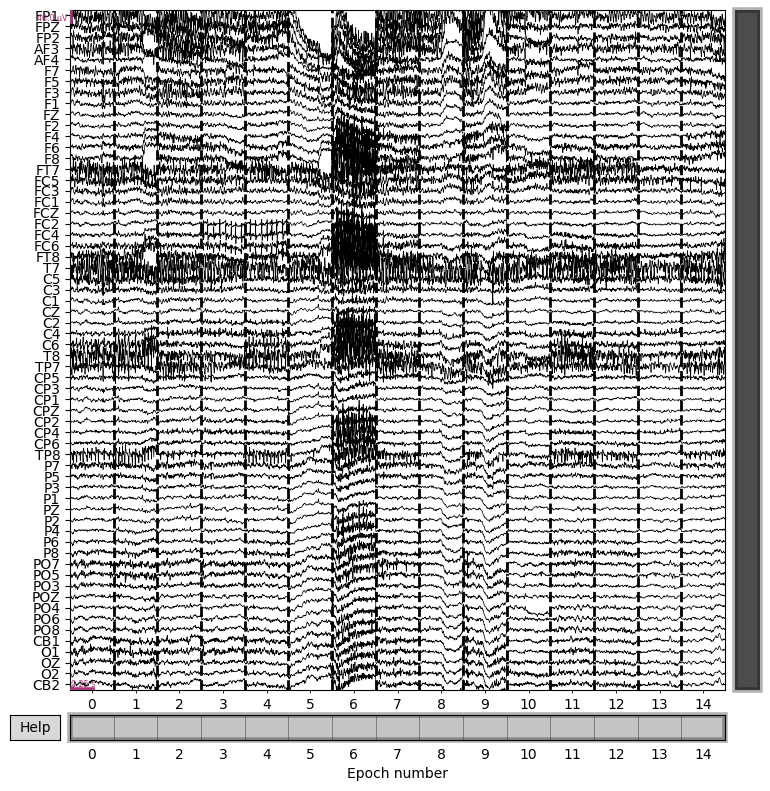

In [52]:
epochs.plot(n_epochs=15, n_channels=62, picks='eeg');

# Rechazo de ensayos

*   3:29 Los artefactos pequeños de alta frecuencia están bien
*   5:39 Parpadeos se remueven con ICA
*   5:39 Si hay ruido en todos los canales podría ser un estornudo o que se rascó. Eliminar el trial.
*   9:24 Si hay ruido en todos los canales pero solo al comienzo antes de que arranque el trial, todo bien. Se puede dejar.
*   9:43 Es movimiento del ojo normal pero si es muy duradero, podría ser que tenía los ojos cerrados (porque es chino)
*   11:10 Si se mueve mucho, podría ser que era medio despistado. Borrar el trial
*   15:21 Si se mueve el canal pero es evidente que hay señal EEG, se puede dejar y corregirlo con ICA
*   15:21 El EMG se remueve si ocurre en durante la línea base del preestímulo.












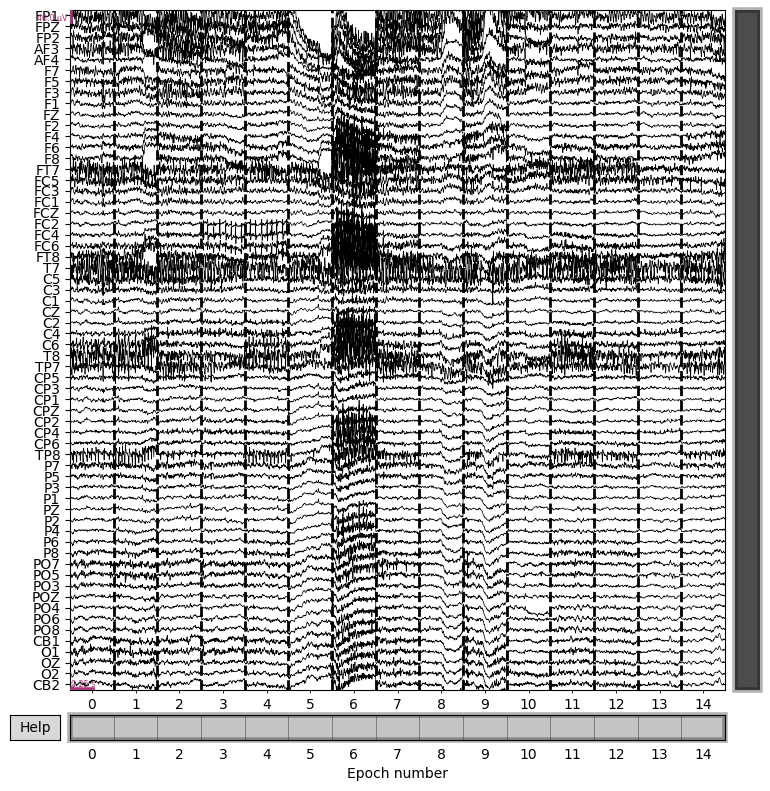

In [67]:
epochs.plot(n_epochs=15, n_channels=62, picks='eeg');

In [68]:
Image(url=image_url, width=400)

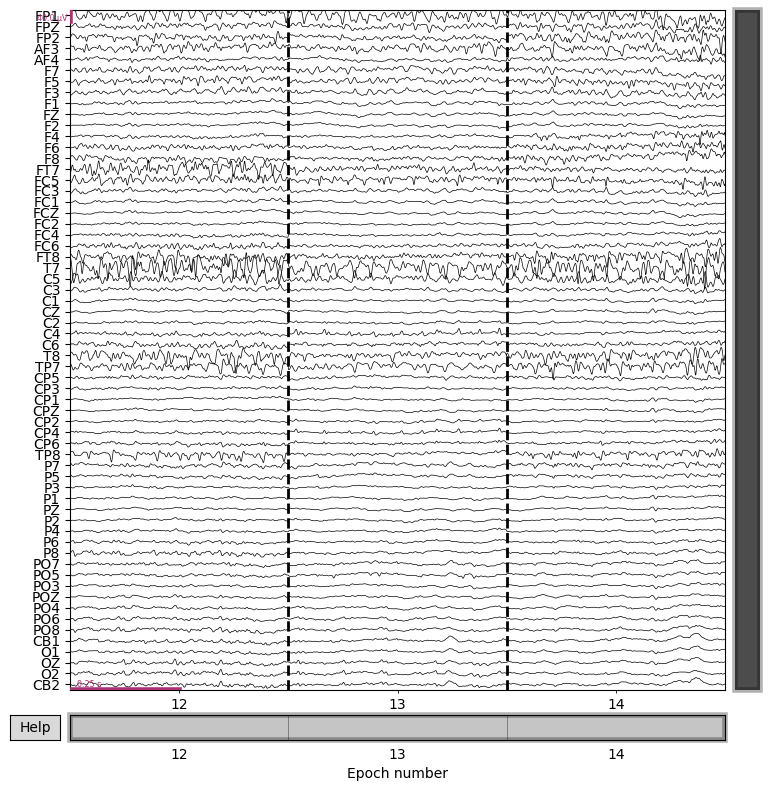

In [79]:
epochs[12:].plot(n_channels=62);

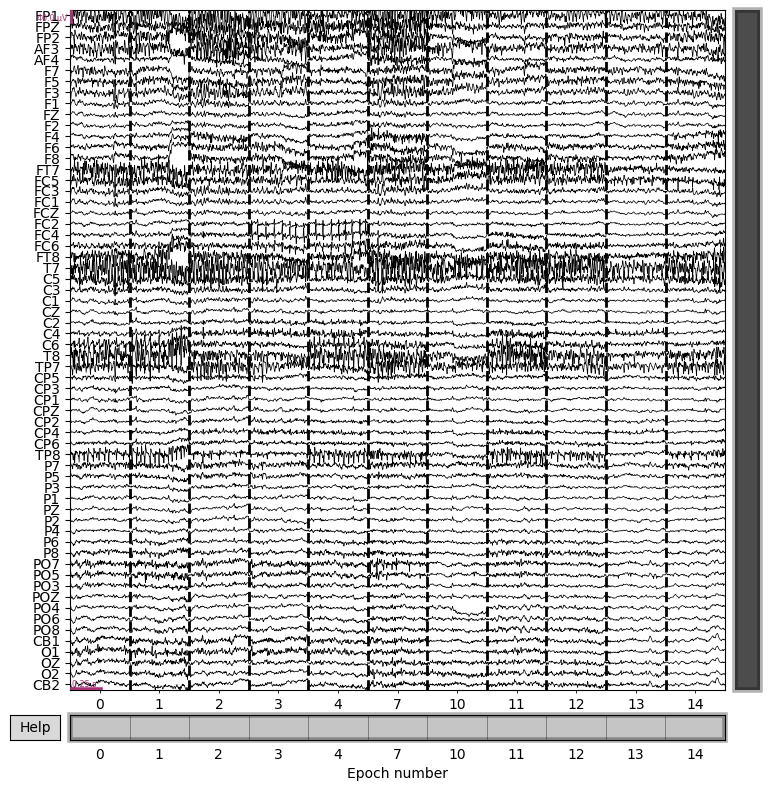

In [94]:
final_epochs.plot(n_channels=62);

In [142]:
epoch_times = {
    1: ([30, 132, 287, 555, 773, 982, 1271, 1628, 1730, 2025, 2227, 2435, 2667, 2932, 3204],
        [102, 228, 524, 742, 920, 1240, 1568, 1697, 1994, 2166, 2401, 2607, 2901, 3172, 3359]),
    2: ([30, 299, 548, 646, 836, 1000, 1091, 1392, 1657, 1809, 1966, 2186, 2333, 2490, 2741],
        [267, 488, 614, 773, 967, 1059, 1331, 1622, 1777, 1908, 2153, 2302, 2428, 2709, 2817]),
    3: ([30, 353, 478, 674, 825, 908, 1200, 1346, 1451, 1711, 2055, 2307, 2457, 2726, 2888],
        [321, 418, 643, 764, 877, 1147, 1284, 1418, 1679, 1996, 2275, 2425, 2664, 2857, 3066])
}

# Función de preprocesamiento

In [151]:
def eeg_preprocess(cnt_file: str,
                   epoch_times: dict[tuple[list[int]]],
                   experiment: int = 1,
                   n_epochs: int = 15,
                   n_channels: int = 62,
                   canales_a_eliminar: list[str] = ['M1', 'M2', 'VEO', 'HEO'],
                   ref_channels: str = 'average',
                   l_freq: float = 0.5,
                   h_freq: float = None,
                   notch_freq: float = 50,
                   t_min: float = -0.2,
                   t_max: float = 0.3,
                   baseline_interval: tuple[float, float] = (-0.2, 0)) -> mne.Epochs:

    """
    Preprocesa datos EEG a partir de un archivo .cnt.

    Parámetros:
    - cnt_file (str): Ruta al archivo .cnt que contiene los datos EEG en bruto.
    - epoch_times (dict[tuple[list[str]]]): Tiempos de inicio y fin de las épocas en cada experimento.
    - experiment (int): Número de experimento en el diccionario de `epoch_times`.
    - n_epochs (int): Número de épocas para mostrar al graficar.
    - n_channels (int): Número de canales para mostrar al graficar.
    - canales_a_eliminar (list[str]): Lista de nombres de canales que se eliminarán de los datos.
    - ref_channels (str): Referencia para la re-referenciación de los datos EEG ('average' para la referencia promedio).
    - l_freq (float): Límite de frecuencia inferior para el filtrado de paso de banda (en Hz).
    - h_freq (float): Límite de frecuencia superior para el filtrado de paso de banda (en Hz).
    - notch_freq (float): Frecuencia para el filtrado notch (generalmente la frecuencia del ruido de línea, por ejemplo, 50 Hz o 60 Hz).
    - t_min (float): Tiempo de inicio para la extracción de épocas (en segundos).
    - t_max (float): Tiempo final para la extracción de épocas (en segundos).
    - baseline_interval (tuple[float, float]): Intervalo de tiempo para la corrección de línea base (en segundos).

    Retorna:
    - epochs: Objeto mne.Epochs que contiene los datos EEG preprocesados.
    """

    print(f"Mostrando el archivo {cnt_file}")

    print(f"Tiempos de inicio: {epoch_times[experiment][0]}")
    print(f"Tiempos de fin: {epoch_times[experiment][1]}")

    raw_data = mne.io.read_raw_cnt(cnt_file, preload=True)
    raw_data.drop_channels(canales_a_eliminar)
    raw_data.set_eeg_reference(ref_channels=ref_channels)
    raw_data.apply_proj()

    print("Referencia de los datos después de la re-referenciación:", raw_data.info['custom_ref_applied'])

    raw_data.filter(l_freq=l_freq, h_freq=h_freq)
    raw_data.notch_filter(freqs=notch_freq)

    sfreq = raw_data.info['sfreq']  # Frecuencia de muestreo de los datos
    events = np.array([[int(inicio * sfreq), 0, id] for id, inicio in enumerate(epoch_times[experiment][0])])

    epochs = mne.Epochs(raw_data, events=events, tmin=t_min, tmax=t_max,
                        baseline=(None, 0), preload=True, reject=None, flat=None)

    epochs.apply_baseline(baseline=baseline_interval)

    epochs.plot(n_epochs=n_epochs, n_channels=n_channels, picks='eeg', title='Señales EEG con ajuste de línea base')
    return epochs

In [121]:
ruta_carpeta = '/content/drive/MyDrive/SEED/EEG_raw/'

archivos = os.listdir(ruta_carpeta)

full_path = sorted([ruta_carpeta + archivo for archivo in archivos])
full_path = full_path[18:] + full_path[:18]

In [156]:
full_path[32]

'/content/drive/MyDrive/SEED/EEG_raw/11_3_20180522.cnt'

Mostrando el archivo /content/drive/MyDrive/SEED/EEG_raw/11_3_20180522.cnt
Tiempos de inicio: [30, 353, 478, 674, 825, 908, 1200, 1346, 1451, 1711, 2055, 2307, 2457, 2726, 2888]
Tiempos de fin: [321, 418, 643, 764, 877, 1147, 1284, 1418, 1679, 1996, 2275, 2425, 2664, 2857, 3066]
Reading 0 ... 3141639  =      0.000 ...  3141.639 secs...


<ipython-input-151-5ff5afe6f523>:42: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw_data = mne.io.read_raw_cnt(cnt_file, preload=True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
No projector specified for this dataset. Please consider the method self.add_proj.
Referencia de los datos después de la re-referenciación: 1 (FIFFV_MNE_CUSTOM_REF_ON)
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Not setting metadata
15 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 501 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)


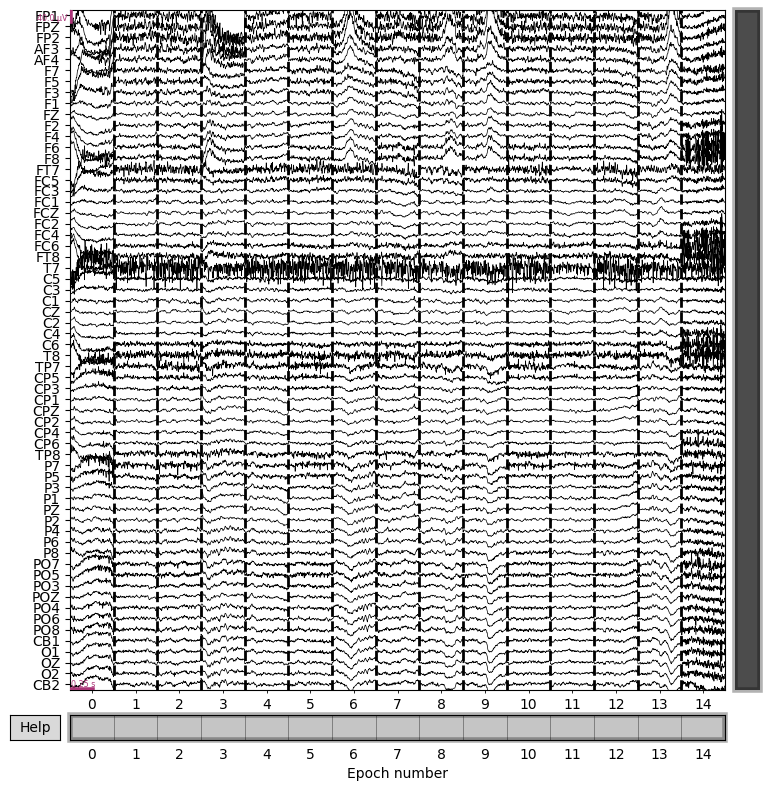

In [157]:
preprocessed_epochs = eeg_preprocess(full_path[32], epoch_times, 3)

In [ ]:
# P: Persona, E: Experimento

epochs_to_remove = {"P1E1": [5, 6, 8, 9],
                    "P1E2": [9],
                    ""
                    }

In [129]:
event_id_exp_2

{0: 'Sad_1',
 1: 'Fear_1',
 2: 'Neutral_1',
 3: 'Disgust_1',
 4: 'Happy_1',
 5: 'Happy_2',
 6: 'Disgust_2',
 7: 'Neutral_2',
 8: 'Sad_2',
 9: 'Fear_2',
 10: 'Neutral_3',
 11: 'Happy_3',
 12: 'Fear_3',
 13: 'Sad_3',
 14: 'Disgust_3'}

In [ ]:
to_remove = set(epochs_to_remove['P1E1'])

all_epochs = set([i for i in range(15)])

final_epochs = list(all_epochs.symmetric_difference(to_remove))
final_epochs = epochs[final_epochs]

In [ ]:
ica = ICA(n_components=20, random_state=97, max_iter=800)  # Ajusta los parámetros según tus necesidades
ica.fit(raw_data)